In [1]:
import numpy as np
from scipy.integrate import odeint
import pylab as plt

In [2]:


Vd_0 = 1/60 / (1+1/60) *( 0.002*3*1800 + 0.5 )

def rect(t,t1,dt,v1, v2):
    return v1+(v2-v1)*(np.abs(t-(t1+dt/2))<dt/2)




    
def V_eff(PSD, p):
    root = 1/p['tau_u_0']*(4*p['nf_0']*p['tau_Vd']*(1/p['tau_u_0'] + 1/p['tau_u_0']/p['ratio_0'])  +  PSD**2/p['tau_u_0'])
    root = np.sqrt(np.maximum(0,root))
    
    return PSD/2 +  p['tau_u_0']*root/2


def eom(y, t, p, s):
        
        
        dVd             = - y[0]/ rect(t,s['STIM'], s['X_STET'], p['tau_u_0']*p['ratio_0'],p['tau_u_1']*p['ratio_1'])\
                          + y[1]/ rect(t,s['STIM'], s['X_STET'], p['tau_u_0'],p['tau_u_1']) \
                          + rect(t,s['STIM'], s['STET'], p['nf_0'],  p['nf_LTP']) \
                          + rect(t,s['STIM'], s['LFS'] , 0        , -p['nf_0'] + p['nf_LTD'] ) \
                          - y[0] * (y[0]+y[1]-y[2]) / p['tau_Vd']
        
        dVs             =   y[0]/ rect(t,s['STIM'], s['X_STET'], p['tau_u_0']*p['ratio_0'],p['tau_u_1']*p['ratio_1'])\
                          - y[1]/ rect(t,s['STIM'], s['X_STET'], p['tau_u_0'],p['tau_u_1']) 
        
        dVpsd           = rect(t, s['STIM']+s['P_ONSET'], s['PROTEIN'],0,1) *  \
                          (y[0]+y[1] - V_eff( y[2], p ))/p['tau_Vd']*p['ratio_psd']
                
        return np.array([dVd,dVs,dVpsd])
    

    
    
def odeint2(eom, y0, times, args):
    rets = [y0]
    for t,dt in zip(times[:-1], (times[1:]-times[:-1])):
        rets.append(rets[-1] + dt* eom(rets[-1],t,args[0],args[1]))
    return np.array(rets)


times = np.array([43,  386,  711, 1010, 1293, 1599, 1922, 2365, 2971, 3575, 4202, 4808, 5393, 5997]).astype(float)
times = np.arange(0,10000,1)    


params = {'tau_u_0':3*900,
          'ratio_0':30/9,
          'tau_Vd':1800,
          'ratio_psd':5,
          'nf_0':0.002*0.12,
          'tau_u_1':3*3.6,
          'ratio_1':500/3,
          'nf_LTP':0.002*0.12*70,
          'nf_LTD':0.002*0}

                           
                           
stim   = {'STIM': 300,
          'STET': 120,
          'X_STET': 120,
          'LFS': 0,
          'PROTEIN': 3600,
          'P_ONSET': 12.5 * 60}   



        

In [3]:
data_LTP_t = 60 * 20/6.5*np.cumsum(np.array([-1.39,1.86,1.76,1.62,1.53,1.66,1.75, 2.4,3.28,3.27, 3.4,3.28, 3.17,3.27]))
data_LTP   = 1 + .5/5.12*np.array([0.2,20.59,8.74,6.45,5.92,6.03,5.00,4.04,3.76,3.83,3.24,4.15,4.36,3.35])
data_LTD_t = 60 * 20/11*np.cumsum(np.array([0,5.7,5.5,5.4,5.7,6.0,5.3,11.6]))
data_LTD   = 1- .25/8.1*np.array([0,4.4,6.3,8.7,8.6,7.9,8.8,8.6])

s1 =   {'STIM': 300,
        'STET': 120,
        'X_STET': 120,
        'LFS': 0,
        'PROTEIN': 3600,
        'P_ONSET': 12.5 * 60}
indices_LTP = (s1['STIM']+data_LTP_t).astype(int)


s2 =   {'STIM': 300,
        'STET': 0,
        'X_STET': 900,
        'LFS': 900,
        'PROTEIN': 3600,
        'P_ONSET': 12.5 * 60}
indices_LTD = (s2['STIM']+data_LTD_t).astype(int)


def error(tau_u_0, ratio_0, tau_Vd, ratio_psd,nf_0,tau_u_1, ratio_1, nf_LTP, nf_LTD):


    # -Vd /tau_b + Vs/tau_u = = -> Vs = tau_b/tau_u Vd 
    
    params = {'tau_u_0':tau_u_0,
              'ratio_0':ratio_0,
              'tau_Vd': tau_Vd,
              'ratio_psd':ratio_psd,
              'nf_0':   nf_0,
              'tau_u_1':tau_u_1,
              'ratio_1':ratio_1,
              'nf_LTP': nf_LTP,
              'nf_LTD': nf_LTD}
    
    
    times=np.arange(6000)
    
    #Vpsd = 0.5
    
    eql  = ratio_0/( 1 + ratio_0)
    # approximation for Veff
    # Veff = params['nf_0']*params['tau_Vd'] + Vpsd 
    
    Veff=1
    Vpsd = Veff - params['nf_0']*params['tau_Vd']
    
    if Vpsd<0:
        return -20
    
    
    y0 = np.array([eql*Veff, (1-eql)*Veff,  Vpsd])
    
    V = odeint(eom, y0, times, args=(params, s1))
    error = sum( ((V[indices_LTP,0]+V[indices_LTP,1])/(V[indices_LTP[0],0]+V[indices_LTP[0],1]) - data_LTP)**2 ) 
    
    V = odeint(eom, y0, times, args=(params, s2))
    error += 9*sum( ((V[indices_LTD,0]+V[indices_LTD,1])/(V[indices_LTP[0],0]+V[indices_LTD[0],1]) - data_LTD)**2 )
  

    if V[-1,2]<0:
        return -20
    else:
        return -error

In [4]:
from bayes_opt import BayesianOptimization,UtilityFunction

pbounds= {'tau_u_0':(2400,3600),
          'ratio_0':(3,4),
          'tau_Vd': (1500,2400),
          'ratio_psd':(4,9),
          'nf_0':   (0.002*0.05 , 0.00025),
          'tau_u_1':(10,30),
          'ratio_1':(200,300),
          'nf_LTP': (0.01,0.02),
          'nf_LTD': (0,0)}



optimizer = BayesianOptimization(
                f=error,
                pbounds=pbounds,
                random_state=1 )




In [5]:
optimizer.probe(
    params = {'tau_u_0':3*900,
          'ratio_0':30/9,
          'tau_Vd':1800,
          'ratio_psd':5,
          'nf_0':0.002*0.12,
          'tau_u_1':3*3.6,
          'ratio_1':500/3,
          'nf_LTP':0.002*0.12*70,
          'nf_LTD':0.002*0},
    lazy=True

)

In [6]:
# prefer exploiting good params
acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)


optimizer.maximize(
    init_points=100,
    n_iter=200,
    acquisition_function=acquisition_function
)

|   iter    |  target   |   nf_0    |  nf_LTD   |  nf_LTP   |  ratio_0  |  ratio_1  | ratio_psd |  tau_Vd   |  tau_u_0  |  tau_u_1  |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -1.137    | 0.00024   | 0.0       | 0.0168    | 3.333     | 166.7     | 5.0       | 1.8e+03   | 2.7e+03   | 10.8      |
| 2         | -2.565    | 0.0001626 | 0.0       | 0.01      | 3.302     | 214.7     | 4.462     | 1.668e+03 | 2.815e+03 | 17.94     |
| 3         | -1.857    | 0.0001808 | 0.0       | 0.01685   | 3.204     | 287.8     | 4.137     | 2.103e+03 | 2.901e+03 | 21.17     |
| 4         | -3.12     | 0.0001211 | 0.0       | 0.01801   | 3.968     | 231.3     | 7.462     | 2.289e+03 | 3.474e+03 | 11.7      |
| 5         | -3.052    | 0.0001059 | 0.0       | 0.01878   | 3.098     | 242.1     | 8.789     | 1.98e+03  | 3.23e+03  | 16.31     |
| 6         | -1.946    | 0.000203  | 0.0       | 0.01018   | 

In [7]:
params = optimizer.max['params']
#params = optimizer.res[-1]['params']
print(params)

{'nf_0': 0.00025, 'nf_LTD': 0.0, 'nf_LTP': 0.02, 'ratio_0': 3.787769967758817, 'ratio_1': 232.5023763795744, 'ratio_psd': 9.0, 'tau_Vd': 1503.2167264252723, 'tau_u_0': 3379.042736072486, 'tau_u_1': 30.0}


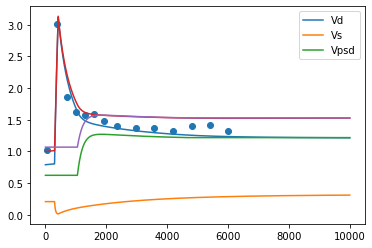

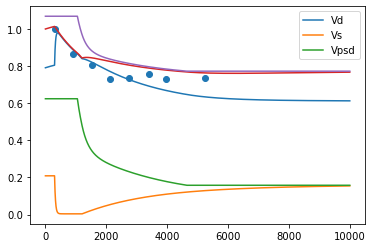

In [8]:
eql  = params['ratio_0']/( 1 + params['ratio_0'])
#Vpsd = 0.5
#Veff = params['nf_0']*params['tau_Vd'] + Vpsd 
Veff=1
Vpsd = Veff-params['nf_0']*params['tau_Vd']


y0 = np.array([eql*Veff, (1-eql)*Veff,  Vpsd])

V = odeint(eom, y0, times, args=(params, s1))

# %matplotlib notebook
plt.figure(1)
plt.plot(times, V[:,0], label='Vd')
plt.plot(times, V[:,1], label='Vs')
plt.plot(times, V[:,2], label='Vpsd')

plt.plot(times, V[:,0]+V[:,1])
plt.plot(times, V_eff( V[:,2], params ) )
plt.scatter(indices_LTP,data_LTP)
plt.legend()

V = odeint(eom, y0, times, args=(params, s2))

plt.figure(2)
plt.plot(times, V[:,0], label='Vd')
plt.plot(times, V[:,1], label='Vs')
plt.plot(times, V[:,2], label='Vpsd')

plt.plot(times, V[:,0]+V[:,1])
plt.plot(times, V_eff( V[:,2], params ) )
plt.scatter(indices_LTD,data_LTD)
plt.legend()

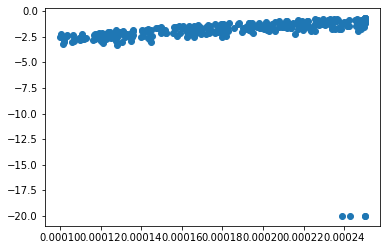

In [9]:
plt.figure()
plt.scatter( [r['params']['nf_0'] for r in optimizer.res], [r['target'] for r in optimizer.res])

In [10]:
optimizer.res[0]

{'target': -1.1373866926622838,
 'params': {'nf_0': 0.00024,
  'nf_LTD': 0.0,
  'nf_LTP': 0.0168,
  'ratio_0': 3.3333333333333335,
  'ratio_1': 166.66666666666666,
  'ratio_psd': 5.0,
  'tau_Vd': 1800.0,
  'tau_u_0': 2700.0,
  'tau_u_1': 10.8}}

In [11]:
params = {'tau_u_0':3*900,
          'ratio_0':30/9,
          'tau_Vd':1800,
          'ratio_psd':5,
          'nf_0':0.002*0.12,
          'tau_u_1':3*3.6,
          'ratio_1':500/3,
          'nf_LTP':0.002*0.12*70,
          'nf_LTD':0.002*0}